## 用卷积神经网络训练Cifar10
For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

## Training an image classifier
We will do the following steps in order:
- Load and normalize the CIFAR10 training and test datasets using torchvision
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

## 1. Load and normalize CIFAR10
Using torchvision, it's extremely easy to load CIFAR10.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='../input/cifar-10-batches-py/', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../input/cifar-10-batches-py/', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.

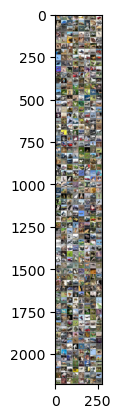

cat   horse truck cat   plane frog  car   car   cat   car   ship  truck ship  ship  frog  frog  truck horse truck horse plane car   frog  dog   truck bird  truck plane bird  car   car   bird  bird  deer  cat   dog   cat   bird  frog  car   dog   cat   dog   ship  ship  cat   frog  cat   bird  deer  horse cat   truck plane ship  truck plane frog  frog  ship  truck truck deer  plane plane frog  deer  deer  deer  horse dog   deer  bird  cat   horse horse frog  horse truck ship  horse plane cat   car   bird  frog  car   deer  dog   bird  dog   truck frog  frog  horse dog   plane truck deer  horse deer  bird  frog  horse plane frog  dog   dog   cat   bird  plane deer  car   car   horse deer  ship  ship  deer  truck plane car   bird  dog   frog  deer  car   plane bird  ship  plane frog  frog  deer  cat   ship  dog   ship  dog   horse dog   truck deer  dog   ship  bird  plane ship  frog  truck ship  bird  bird  car   truck truck bird  dog   cat   deer  cat   cat   truck cat   car   bird  car 

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 2. Define a Convolutional Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.0  Device: cuda


In [7]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)   # kernel_size=5, padding=2, stride=1
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [9]:
print(len(trainloader))

98


In [10]:
def train(epoch, log_interval=50):
    # Set model to training mode
    net.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(trainloader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = net(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data.item()))

In [11]:
def validate(loss_vector, accuracy_vector):
    net.eval()
    val_loss, correct = 0, 0
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(testloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(testloader.dataset), accuracy))


In [12]:
%%time
epochs = 30

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.304912
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.300528

Validation set: Average loss: 2.2877, Accuracy: 1606/10000 (16%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.288610
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.219124

Validation set: Average loss: 2.0300, Accuracy: 2645/10000 (26%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.045622
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.921005

Validation set: Average loss: 1.8143, Accuracy: 3377/10000 (34%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.856497
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.704899

Validation set: Average loss: 1.6933, Accuracy: 3786/10000 (38%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.694214
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.611493

Validation set: Average loss: 1.5880, Accuracy: 4250/10000 (42%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.590545
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.534018

Validation set: Average loss: 1.5062, Accuracy: 4575/10000 (46%)

Train Epoch: 7 [0/50000 (0%)

In [13]:
print(lossv)
print(accv)

[2.2877450704574587, 2.029958313703537, 1.8143002092838287, 1.6933319211006164, 1.587992125749588, 1.5062284171581268, 1.4444412291049957, 1.3535873413085937, 1.3175646662712097, 1.2805797398090362, 1.2358755946159363, 1.2039601266384126, 1.2151055455207824, 1.1577746868133545, 1.154861968755722, 1.1471413254737854, 1.1127058446407319, 1.1287314355373383, 1.1150144279003142, 1.0941513031721115, 1.107020726799965, 1.0563687533140182, 1.0691073775291442, 1.065127283334732, 1.0617719620466233, 1.0689144402742385, 1.038637325167656, 1.0594932705163955, 1.0304052889347077, 1.0751130998134613]
[tensor(16.0600), tensor(26.4500), tensor(33.7700), tensor(37.8600), tensor(42.5000), tensor(45.7500), tensor(47.4600), tensor(51.), tensor(53.3800), tensor(54.3500), tensor(55.4600), tensor(57.2900), tensor(57.0100), tensor(58.5200), tensor(59.4100), tensor(59.7300), tensor(60.2900), tensor(60.0600), tensor(60.7500), tensor(61.1800), tensor(60.7800), tensor(62.7900), tensor(62.2200), tensor(63.0100), 

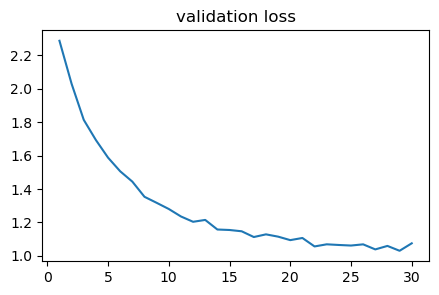

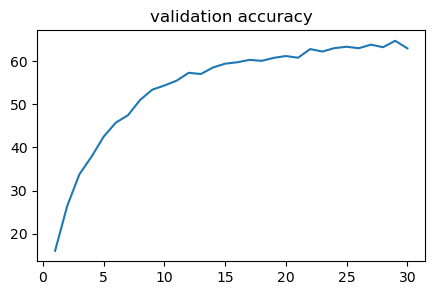

In [14]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

Let’s quickly save our trained model:

In [15]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

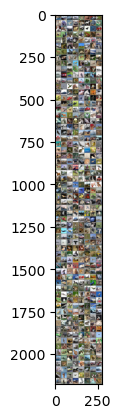

GroundTruth:  cat   ship  ship  plane


In [16]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [17]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

In [18]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [19]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [21]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 62.1 %
Accuracy for class: car   is 82.1 %
Accuracy for class: bird  is 49.6 %
Accuracy for class: cat   is 47.2 %
Accuracy for class: deer  is 35.4 %
Accuracy for class: dog   is 55.3 %
Accuracy for class: frog  is 81.0 %
Accuracy for class: horse is 69.3 %
Accuracy for class: ship  is 84.0 %
Accuracy for class: truck is 63.6 %


# RESNET18

In [54]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34

    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


In [55]:
class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=10):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [56]:
model=resnet18()
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [57]:
model=model.to(device)

In [58]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [59]:
def train(epoch, log_interval=50):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(trainloader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data.item()))

In [60]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(testloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(testloader.dataset), accuracy))


In [61]:
%%time
epochs = 30

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.362828
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.357990

Validation set: Average loss: 1.1628, Accuracy: 5814/10000 (58%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.983482
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.027209

Validation set: Average loss: 1.2432, Accuracy: 5804/10000 (58%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.633929
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.638934

Validation set: Average loss: 1.0839, Accuracy: 6400/10000 (64%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.448743
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.471357

Validation set: Average loss: 1.0127, Accuracy: 6885/10000 (69%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.321378
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.267263

Validation set: Average loss: 1.8425, Accuracy: 5542/10000 (55%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.198639
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.109040

Validation set: Average loss: 1.2685, Accuracy: 6867/10000 (69%)

Train Epoch: 7 [0/50000 (0%)

In [114]:
lossv=[1.8424743473529817,1.1628164172172546, 1.2431526601314544, 1.0839487344026566, 1.012735441327095,  1.2685284435749054, 1.1464801728725433, 1.0911928087472915, 0.9414075911045074, 0.9006227761507034, 0.8733943849802017, 0.8753824204206466, 0.8772015184164047, 0.8810045659542084, 0.8831397294998169, 0.8856752693653107, 0.8879411369562149, 0.8932823687791824, 0.896161749958992, 0.8986354947090149, 0.898526182770729, 0.9017041057348252, 0.9057591944932938, 0.9078369855880737, 0.9095508426427841, 0.9103667616844178, 0.9136103391647339, 0.9131608724594116, 0.9150025457143783, 0.9168427675962448]
accv=[58.1400,58.0400, 55.4200,64, 68.8500,68.6700, 71.8100, 74.0400,77.9200, 78.9600, 79.6500, 79.8800,79.9300, 80.0400, 80.0200, 80.1100,79.9500, 80.0900, 80.1000, 80.0200, 80.0300, 80.0700,80.0600, 79.9700, 80, 80.0400, 80, 80.0500, 80.1000,80.0100]

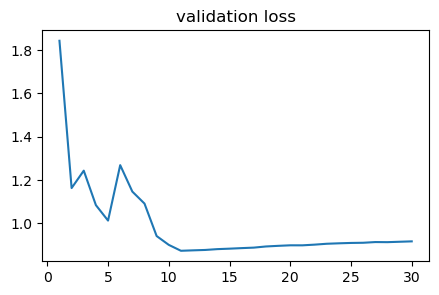

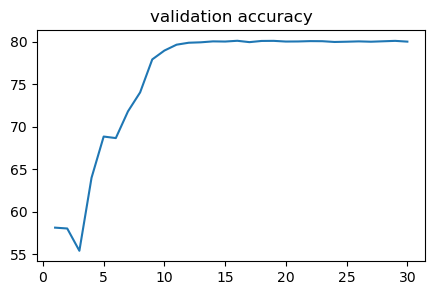

In [115]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [66]:
PATH = './cifar_resnet18.pth'
torch.save(model.state_dict(), PATH)

# DenseNet

In [75]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torchvision.models.detection.retinanet import RetinaNet
from torch import Tensor
from typing import Any, List, Tuple

In [92]:
class _DenseLayer(nn.Module):
    def __init__(
        self,
        num_input_features: int,
        growth_rate: int,
        bn_size: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseLayer, self).__init__()
        self.norm1: nn.BatchNorm2d
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.relu1: nn.ReLU
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.conv1: nn.Conv2d
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False))
        self.norm2: nn.BatchNorm2d
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.relu2: nn.ReLU
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.conv2: nn.Conv2d
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False))
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[Tensor]) -> Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input: List[Tensor]) -> bool:
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input: List[Tensor]) -> Tensor:
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: List[Tensor]) -> Tensor:
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: Tensor) -> Tensor:
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features: Tensor) -> Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):

    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 10,
        memory_efficient: bool = False
    ) -> None:

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out


def _load_state_dict(model: nn.Module, model_url: str, progress: bool) -> None:
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)


def _densenet(
    arch: str,
    growth_rate: int,
    block_config: Tuple[int, int, int, int],
    num_init_features: int,
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> DenseNet:
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model


def densenet18(pretrained: bool = False, progress: bool = True, input_size: Tuple[int, int, int] = None, **kwargs: Any) -> DenseNet:
    model = _densenet('', 32, (4, 4, 4, 4), 64, pretrained, progress, **kwargs)
    model.name = "DenseNet18"
    return model

In [93]:
model=densenet18()
print(model)
model=model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [94]:
model=model.to(device)

In [95]:

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [96]:
def train(epoch, log_interval=50):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(trainloader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data.item()))

In [97]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(testloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(testloader.dataset), accuracy))


In [98]:
%%time
epochs = 30

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.341916
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.392194

Validation set: Average loss: 1.2676, Accuracy: 5436/10000 (54%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.279364
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.045519

Validation set: Average loss: 1.1474, Accuracy: 5979/10000 (60%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.942178
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.920846

Validation set: Average loss: 1.0737, Accuracy: 6298/10000 (63%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.781040
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.698224

Validation set: Average loss: 1.0690, Accuracy: 6482/10000 (65%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.652778
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.699981

Validation set: Average loss: 0.8857, Accuracy: 7073/10000 (71%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.599240
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.528275

Validation set: Average loss: 0.8989, Accuracy: 7039/10000 (70%)

Train Epoch: 7 [0/50000 (0%)

In [99]:
print(lossv)
print(accv)

[1.267634379863739, 1.1474152147769927, 1.0736951887607575, 1.0689874470233918, 0.8856650143861771, 0.8989075809717179, 0.8359243422746658, 0.9771507233381271, 0.882328188419342, 0.940411502122879, 0.9835135728120804, 1.0034926503896713, 1.0390881836414336, 1.166170021891594, 1.1994135320186614, 1.1638577044010163, 1.1561027765274048, 1.1770509362220765, 1.1858807981014252, 1.280832475423813, 1.2793200433254241, 1.3121986269950867, 1.325224381685257, 1.3166644036769868, 1.3264707624912262, 1.393555462360382, 1.4067586183547973, 1.5146065413951875, 1.3864086091518402, 1.449845439195633]
[tensor(54.3600), tensor(59.7900), tensor(62.9800), tensor(64.8200), tensor(70.7300), tensor(70.3900), tensor(72.7700), tensor(70.4300), tensor(73.0500), tensor(73.5900), tensor(72.6400), tensor(73.2900), tensor(73.6700), tensor(72.5700), tensor(71.9100), tensor(73.9500), tensor(74.7800), tensor(74.6700), tensor(74.4200), tensor(73.5300), tensor(74.3700), tensor(74.9400), tensor(74.9700), tensor(75.3000)

In [132]:
lossv=[1.267634379863739, 1.1474152147769927, 1.0736951887607575, 1.0689874470233918, 0.8856650143861771, 0.8989075809717179, 0.8359243422746658, 0.9771507233381271, 0.882328188419342, 0.940411502122879, 0.9835135728120804, 1.0034926503896713, 1.0390881836414336, 1.166170021891594, 1.1994135320186614, 1.1638577044010163, 1.1561027765274048, 1.1770509362220765, 1.1858807981014252, 1.280832475423813, 1.2793200433254241, 1.3121986269950867, 1.325224381685257, 1.3166644036769868, 1.3264707624912262, 1.393555462360382, 1.4067586183547973, 1.5146065413951875, 1.3864086091518402, 1.449845439195633]

In [133]:
lossv.reverse()


In [140]:
lossv=[1.449845439195633, 1.3864086091518402, 1.5146065413951875, 1.4067586183547973, 1.393555462360382, 1.3264707624912262, 1.3166644036769868, 1.325224381685257, 1.3121986269950867, 1.2793200433254241, 1.280832475423813, 1.1858807981014252, 1.1770509362220765, 1.1474152147769927,1.1561027765274048, 1.267634379863739, 1.1638577044010163, 1.1994135320186614, 1.166170021891594,  1.0689874470233918, 1.0736951887607575,1.0390881836414336, 1.0034926503896713, 0.9835135728120804, 0.940411502122879, 0.882328188419342, 0.9771507233381271, 0.8359243422746658, 0.8989075809717179, 0.8856650143861771]

In [135]:
accv=[54.3600, 59.7900, 62.9800, 64.8200, 70.7300, 70.3900, 72.7700, 70.4300, 73.0500, 73.5900, 72.6400, 73.2900, 73.6700, 72.5700, 71.9100, 73.9500, 74.7800, 74.6700, 74.4200, 73.5300, 74.3700, 74.9400, 74.9700, 75.3000, 75.1800, 75.3700, 76.1500, 74.9500, 76.3700, 75.9400]

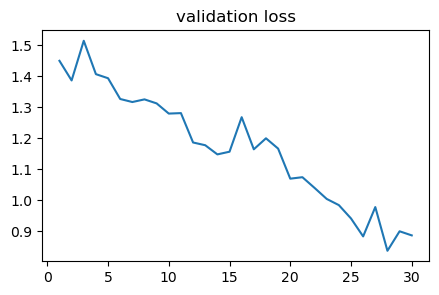

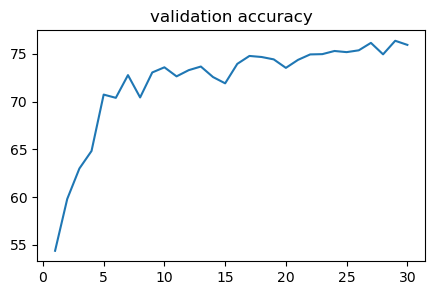

In [141]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [108]:
PATH = './cifar_densenet18.pth'
torch.save(model.state_dict(), PATH)

# se-densenet

In [166]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(growth_rate)
        self.conv2 = nn.Conv2d(growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.se = SEBlock(growth_rate)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.se(out)
        out = torch.cat([out, x], 1)
        return out

class DenseNetSE(nn.Module):
    def __init__(self, growth_rate=12, block_config=(4,4,4,4), num_classes=10, reduction=16):
        super(DenseNetSE, self).__init__()

        self.growth_rate = growth_rate

        num_channels = 2*growth_rate

        self.features = nn.Sequential(
            nn.Conv2d(3, num_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        for i, num_layers in enumerate(block_config):
            block = nn.Sequential()
            for j in range(num_layers):
                layer = DenseLayer(num_channels, growth_rate)
                block.add_module('Layer_{}'.format(j), layer)
                num_channels += growth_rate
            self.features.add_module('Block_{}'.format(i), block)
            if i != len(block_config)-1:
                transition = nn.Sequential(
                    nn.BatchNorm2d(num_channels),
                    nn.Conv2d(num_channels, num_channels//2, kernel_size=1, bias=False),
                    nn.ReLU(inplace=True),
                    nn.AvgPool2d(kernel_size=2, stride=2)
                )
                self.features.add_module('Transition_{}'.format(i), transition)
                num_channels //= 2
        
        self.features.add_module('BN_Last', nn.BatchNorm2d(num_channels)) # 加上全局BN层

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Linear(num_channels, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out



In [167]:
model=DenseNetSE()
print(model)
model=model.to(device)

DenseNetSE(
  (features): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (Block_0): Sequential(
      (Layer_0): DenseLayer(
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (se): SEBlock(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=12, out_features=0, bias=False)
            (1): ReLU(inplace=True)
            (2): Linear(in_fe

In [168]:

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [169]:
def train(epoch, log_interval=50):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(trainloader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data.item()))

In [170]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(testloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(testloader.dataset), accuracy))


In [171]:
%%time
epochs = 30

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.384989
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.319617

Validation set: Average loss: 1.1380, Accuracy: 5925/10000 (59%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.127385
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.977817

Validation set: Average loss: 1.0132, Accuracy: 6437/10000 (64%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.909472
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.801991

Validation set: Average loss: 0.8582, Accuracy: 6959/10000 (70%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.748467
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.725658

Validation set: Average loss: 0.8642, Accuracy: 7005/10000 (70%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.669828
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.622106

Validation set: Average loss: 0.7729, Accuracy: 7372/10000 (74%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.550187
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.626118

Validation set: Average loss: 0.6827, Accuracy: 7666/10000 (77%)

Train Epoch: 7 [0/50000 (0%)

In [173]:
print(lossv)

[1.1379718244075776, 1.0132341474294662, 0.858212673664093, 0.8641647428274155, 0.7728931307792664, 0.6826693445444107, 0.7215118110179901, 0.7127525091171265, 0.7013566195964813, 0.6782381623983383, 0.6801645368337631, 0.6767751008272171, 0.7149040639400482, 0.8290792405605316, 0.7501459121704102, 0.8033342480659484, 0.8121947288513184, 0.8387530416250228, 0.9493277311325073, 0.8906324148178101, 0.8634212732315063, 0.9368658363819122, 0.933231982588768, 0.967215645313263, 0.9824681431055069, 0.9912195384502411, 1.0670056819915772, 0.9838872015476227, 1.056453076004982, 1.0720302611589432]


In [179]:
lossv=[1.1379718244075776,  1.0670056819915772, 0.9838872015476227, 1.056453076004982, 1.0720302611589432,1.0132341474294662, 0.858212673664093, 0.8641647428274155,  0.9912195384502411, 0.9368658363819122,0.9824681431055069, 0.933231982588768, 0.967215645313263,0.9493277311325073, 0.8906324148178101, 0.7501459121704102, 0.8033342480659484, 0.8121947288513184,  0.8634212732315063,0.8387530416250228,   0.8290792405605316,0.7728931307792664, 0.6826693445444107, 0.7215118110179901, 0.7127525091171265, 0.7013566195964813, 0.6782381623983383, 0.6801645368337631, 0.6767751008272171, 0.7149040639400482]

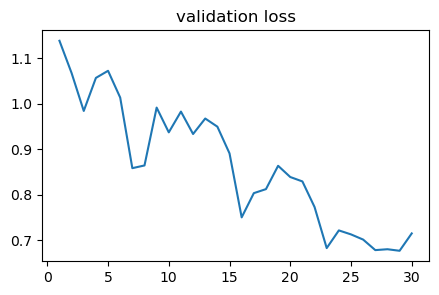

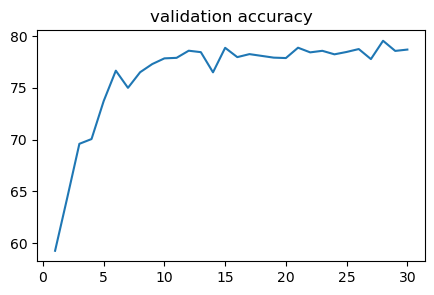

In [181]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets


In [2]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        out = self.avg_pool(x).view(batch_size, channels, 1, 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return x * out


In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class SENet(nn.Module):
    def __init__(self, block, layers, num_classes=10, reduction=16):
        super(SENet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.se = SEBlock(512 * block.expansion, reduction)

    def make_layer(self, block, channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, channels, stride, downsample))
        self.in_channels = channels * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_channels, channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.se(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [6]:
net = SENet(BasicBlock, [2, 2, 2, 2], reduction=16)
print(net)

SENet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False